In [11]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from preprocess import Dataset
from models_nn import CNN_LSTM_Model, LSTMModel, LSTM_Seq2Seq

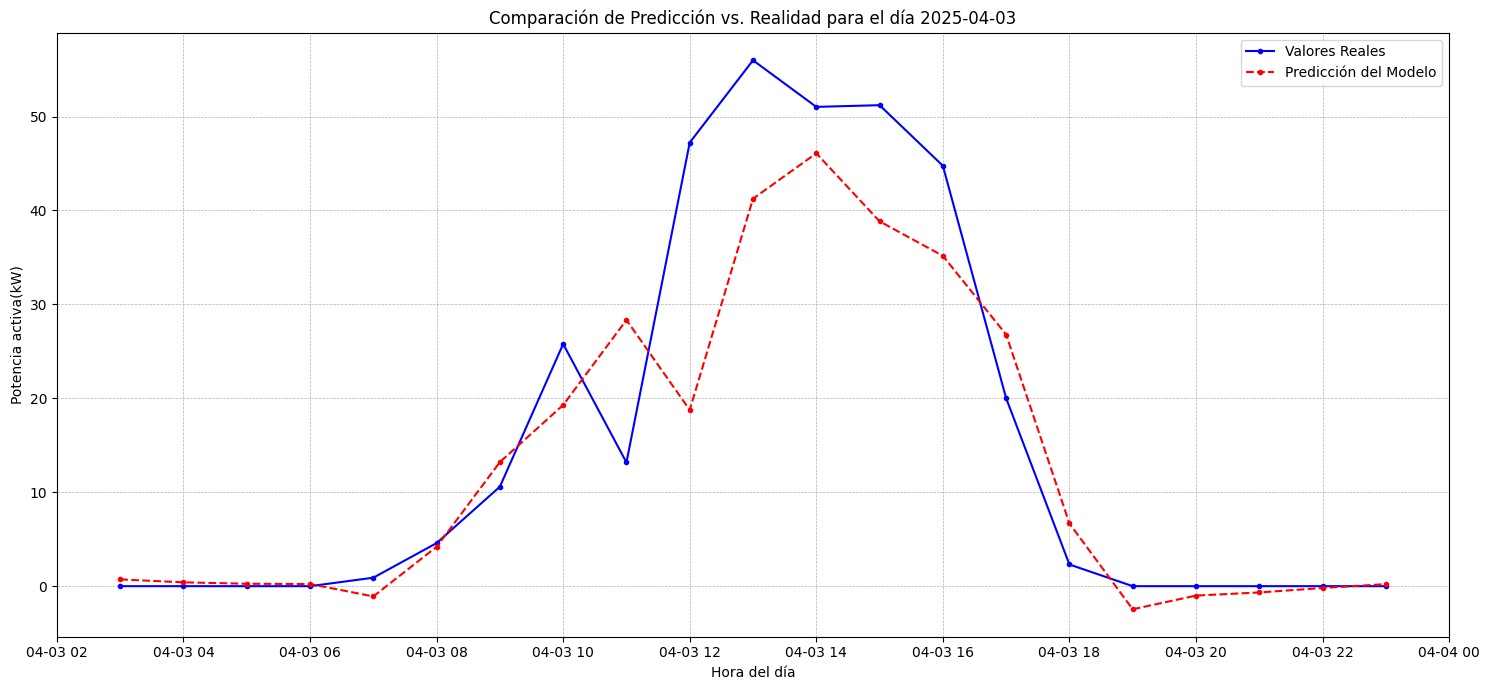

In [12]:
# --- CONFIGURACIÓN ---
# Ajusta estas variables según tus necesidades
DIA_A_TESTEAR = '2025-01-16'
DIA_A_TESTEAR = '2025-02-07'
DIA_A_TESTEAR = '2025-04-03'

RUTA_MODELO = 'E:\Dev\Deep-Solar-Grid\saved_models\lstm_multivariado.pth'
RUTA_MODELO = 'E:\Dev\Deep-Solar-Grid\saved_models\cnn_lstm_model.pth'
RUTA_MODELO = 'E:\Dev\Deep-Solar-Grid\saved_models\seq2seq_lstm_model_2.pth'
RUTA_MODELO = 'E:\Dev\Deep-Solar-Grid\saved_models\lstm_simple_met.pth'
RUTA_DATOS_TRAIN = 'E:\Dev\Deep-Solar-Grid\dataset_final_train.csv' # <-- Se necesita para ajustar el Scaler
RUTA_DATOS_TEST = 'E:\Dev\Deep-Solar-Grid\dataset_final_test.csv'

# Parámetros que DEBEN COINCIDIR con los del script de entrenamiento
n_pasos = 3
hidden_layer_size = 256
seq2seq = 'seq2seq_lstm' in RUTA_MODELO

dataset = Dataset(RUTA_DATOS_TRAIN, RUTA_DATOS_TEST, n_pasos=n_pasos, seq2seq=seq2seq)



# --- 2. SELECCIÓN DEL DÍA Y PREPARACIÓN DE DATOS PARA INFERENCIA ---
# Filtrar los datos para obtener solo el día seleccionado
try:
    # Convertir la fecha de string a objeto de fecha para la comparación
    fecha_obj = pd.to_datetime(DIA_A_TESTEAR).date()
    datos_dia_scaled = dataset.df_test_scaled[dataset.df_test_scaled.index.date == fecha_obj]
    # También obtenemos los datos originales para la comparación final
    datos_dia_reales = dataset.df_test[dataset.df_test.index.date == fecha_obj]

    if datos_dia_scaled.empty:
        raise ValueError("No se encontraron datos para la fecha especificada.")

except Exception as e:
    print(f"Error al procesar la fecha: {e}")
    exit()

# Crear ventanas para el día seleccionado
X_dia, y_dia_real_scaled = dataset.crear_ventanas_multivariado(datos_dia_scaled.values, n_pasos)

if X_dia.shape[0] == 0:
    print(f"No hay suficientes datos en el día {DIA_A_TESTEAR} para crear una ventana completa (se necesitan al menos {n_pasos + 1} registros).")
    exit()

# Convertir a tensor y mover al dispositivo
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.xpu.is_available():
    device = torch.device("xpu")
else:
    device = torch.device("cpu")

X_dia_tensor = torch.from_numpy(X_dia).float().to(device)

# Instanciar el modelo
if 'lstm_simple' in RUTA_MODELO:
    model = LSTMModel(input_size=dataset.n_features, hidden_layer_size=hidden_layer_size).to(device)
elif 'cnn_lstm' in RUTA_MODELO:
    model = CNN_LSTM_Model(input_size=dataset.n_features, hidden_layer_size=hidden_layer_size).to(device)
# Cargar los pesos guardados
elif 'seq2seq_lstm' in RUTA_MODELO:
    model = LSTM_Seq2Seq(input_size=dataset.n_features, hidden_layer_size=hidden_layer_size, output_sequence_len=10).to(device)
try:
    model.load_state_dict(torch.load(RUTA_MODELO, map_location=device))
except FileNotFoundError:
    print(f"Error: No se encontró el archivo del modelo en '{RUTA_MODELO}'. Asegúrate de que la ruta sea correcta.")
    exit()

# Poner en modo de evaluación y realizar la predicción
model.eval()
with torch.no_grad():
    predicciones_tensor = model(X_dia_tensor)


# --- 4. PROCESAMIENTO DE RESULTADOS Y VISUALIZACIÓN ---
# Mover predicciones a la CPU y convertir a NumPy
predicciones_np = predicciones_tensor.cpu().numpy()

if seq2seq:
    # Para la visualización, tomamos solo el primer paso de cada secuencia predicha
    # Si predicciones_np es (21, 10), esto selecciona la primera columna, resultando en (21,)
    predicciones_a_graficar = predicciones_np[:, 0]
else:
    # Para modelos no-Seq2Seq, la salida ya es de un solo paso
    predicciones_a_graficar = predicciones_np.flatten()

# Invertir la escala de las predicciones que hemos seleccionado
predicciones_padded = np.zeros((len(predicciones_a_graficar), dataset.n_features))
predicciones_padded[:, 0] = predicciones_a_graficar
predicciones_desescaladas = dataset.scaler.inverse_transform(predicciones_padded)[:, 0]

num_predicciones = len(predicciones_a_graficar)
valores_reales_dia = datos_dia_reales[dataset.features[0]].values[n_pasos : n_pasos + num_predicciones]

# Preparar el índice para el gráfico
plot_index = datos_dia_reales.index[n_pasos : n_pasos + num_predicciones]

# Graficar
plt.figure(figsize=(15, 7))
plt.plot(plot_index, valores_reales_dia, label='Valores Reales', color='blue', marker='.', linestyle='-')
plt.plot(plot_index, predicciones_desescaladas, label='Predicción del Modelo', color='red', marker='.', linestyle='--')
plt.title(f'Comparación de Predicción vs. Realidad para el día {DIA_A_TESTEAR}')
plt.xlabel('Hora del día')
plt.ylabel(dataset.features[0])
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()